# [AI503 Project] Gaussian Process Regression in Diffusion Models for Time Series Data

In this project, we explore how to incorporate **Gaussian Process Regression (GPR)** into a **Diffusion Model** for one-dimensional time series data. The general idea is as follows:

1. **Diffusion Model Setup**:  
   We start with a diffusion model that progressively adds noise to the data through a forward noising process. Formally, if we denote the original data as $x_0$, at each diffusion step $t$ we obtain:
   $$
   x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, \quad \epsilon \sim N(0,I),
   $$
   where $\bar{\alpha}_t$ is a function of the noise schedule. The model then learns to reverse this process, ultimately attempting to recover a clean estimate of $x_0$ from a noisy $x_t$.

2. **Gaussian Process Regression (GPR) as an Energy Function**:  
   GPR will be employed to guide the diffusion reverse process. The GPR model provides a predictive mean and variance, which can be interpreted as an energy landscape:
   $$
   E(x) = \frac{(x - \mu_{\text{GPR}})^2}{2 \sigma_{\text{GPR}}^2},
   $$
   where $\mu_{\text{GPR}}$ and $\sigma_{\text{GPR}}$ are the GPR predictive mean and standard deviation for the target time step. By treating the GPR output as an energy function, we can modify the reverse diffusion step to push our sample $x_t$ towards regions favored by the GPR prediction, potentially achieving more accurate estimates of the underlying signal.

3. **Time Series Application**:  
   We focus on a real-world time series dataset - PM2.5 measurement. After applying the diffusion model to denoise the data, we use GPR to guide the denoising trajectory. We will also compare scenarios with and without GPR guidance, and even introduce Stein Variational Gradient Descent (SVGD) steps to refine the final samples.

## Set Up

The code cell below sets up the environment and imports all the necessary libraries. We define random seeds for reproducibility, and import packages.

Please ensure that all packages are successfully installed. If there is uninstalled package or library, please run the code as below:

e.g. scikit-learn is uninstalled
```
! pip install scikit-learn
```


In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

### Visualizing the Synthetic Time Series

We need to gain an intuitive understanding of the signal and the added noise before applying the diffusion model and GPR guidance.

1. **Plotting the True Function**:  
   We use `plt.plot(time, y_true, ...)` to draw the continuous underlying signal:
   $$
   y_{\text{true}}(t) = \sin(t) + 0.5 \sin(2t) + 0.1t.
   $$
   This gives us a smooth baseline curve that combines sinusoidal components and a linear trend.

2. **Plotting the Noisy Observations**:  
   With `plt.scatter(time, y_observed, ...)`, we overlay the noisy data points:
   $$
   y_{\text{observed}}(t) = y_{\text{true}}(t) + \sigma \epsilon,
   $$
   where $\sigma = 0.2$ and $\epsilon \sim N(0,1)$. These scattered red points represent a more realistic scenario where measurements contain random fluctuations and uncertainty.


In [2]:
time = np.linspace(0, 10, 500)

def true_function(t):
    return np.sin(t) + 0.5*np.sin(2*t) + 0.1*t

y_true = true_function(time)

noise_std = 0.2
y_observed = y_true + noise_std * np.random.randn(len(time))


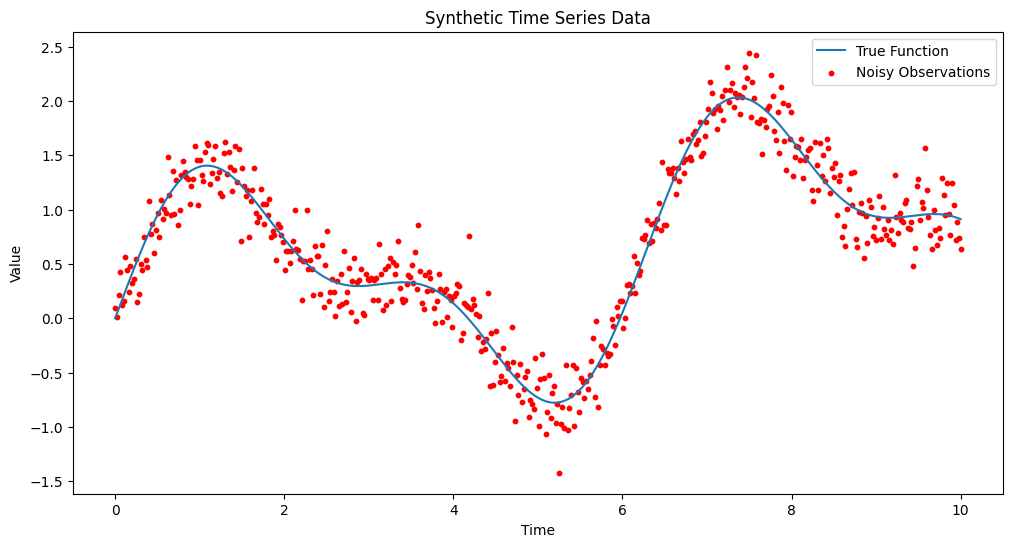

In [3]:
plt.figure(figsize=(12, 6))
plt.plot(time, y_true, label='True Function')
plt.scatter(time, y_observed, color='red', s=10, label='Noisy Observations')
plt.title('Synthetic Time Series Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

### Splitting Data into Training and Test Sets

We partition our time series data into separate training and test sets. By doing so, we ensure that the model is trained on one portion of the data and evaluated on a distinct, unseen portion, which helps prevent overfitting and provides a more realistic measure of the model's predictive performance.

- **`train_test_split`**:  
  We use `train_test_split` to randomly select 80% of the data as training and 20% as testing. The `random_state=42` ensures reproducibility of the split.

- **Training Data**:
  - `time_train`: The time values corresponding to the training portion.
  - `y_train`: The observed noisy values used for model training.
  - `y_true_train`: The underlying true values corresponding to the training portion, for reference and evaluation.

- **Test Data**:
  - `time_test`: The time values for the test portion.
  - `y_test`: The observed noisy values for testing.
  - `y_true_test`: The true values for the test portion, allowing us to gauge how well the model performs on data it hasn’t seen during training.


In [4]:
# Split indices for training and testing
train_indices, test_indices = train_test_split(np.arange(len(time)), test_size=0.2, random_state=42)

# Training data
time_train = time[train_indices]
y_train = y_observed[train_indices]
y_true_train = y_true[train_indices]

# Test data
time_test = time[test_indices]
y_test = y_observed[test_indices]
y_true_test = y_true[test_indices]

### Diffusion Model: Mathematical Foundation and Connection.

The core idea behind the diffusion model is to gradually transform clean data $x_0$ into a noisy version $ x_t $ through a forward process, and then learn to invert this process. By the end of training, we aim to start from a noisy sample and recover something close to $x_0$.

**Forward Diffusion Process**:
- We define a schedule of noise levels $\beta_t$, where $ 0 < \beta_t < 1 $. From these, we compute:
  $$
  \alpha_t = 1 - \beta_t, \quad \text{and} \quad \bar{\alpha}_t = \prod_{s=1}^t \alpha_s.
  $$
- Given an original data point $ x_0 $, the forward diffusion process produces:
  $$
  x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon, \quad \epsilon \sim \mathcal{N}(0, I).
  $$
  This means that as $t$ increases, more noise is mixed in, and $x_t$ becomes less distinguishable from random noise.

**Reversing the Process**:
- The diffusion model's ultimate goal is to learn the reverse mapping: given a noisy $x_t$, predict and remove the noise to obtain a cleaner version closer to $x_0$.
- In practice, our neural network (the `DenoisingNetwork`) is trained to predict the noise $\epsilon$ that was added, given $x_t$ and knowledge about the timestep $t$.

- **Number of Steps & Noise Schedule**: We set `num_diffusion_steps` and define a linear schedule for $\beta_t$. From this, we compute $\alpha_bars$.
- **`q_sample` Function**: Implements the forward noising equation. This is crucial, as it provides training samples at arbitrary timesteps $t$.
- **`DiffusionDataset`**: Randomly picks a timestep $t$, applies `q_sample` to produce a noisy sample $x_t$ and the corresponding noise $\epsilon$. These serve as training examples for the denoising model.
- **`DenoisingNetwork`**: A neural network mapping $(x_t, \text{time}, t)$ to the predicted noise $\epsilon$. By learning to predict $\epsilon$, we effectively learn how to invert the diffusion process.


Once the diffusion model can reliably remove noise, we can incorporate GPR as an additional "energy-based guidance" to push the recovered data towards more plausible or more accurate predictions.


In [5]:
num_diffusion_steps = 100

beta_start = 0.0001
beta_end = 0.02
betas = np.linspace(beta_start, beta_end, num_diffusion_steps)

alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas)

def q_sample(x0, t):
    if np.isscalar(t):
        t = np.full(len(x0), t)
    else:
        t = np.array(t)
    sqrt_alpha_bar_t = np.sqrt(alpha_bars[t])
    sqrt_one_minus_alpha_bar_t = np.sqrt(1 - alpha_bars[t])
    epsilon = np.random.randn(len(x0))
    x_t = sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * epsilon
    return x_t, epsilon


In [6]:
class DiffusionDataset(Dataset):
    def __init__(self, x0, time, num_steps):
        self.x0 = x0
        self.time = time
        self.num_steps = num_steps

    def __len__(self):
        return len(self.x0)

    def __getitem__(self, idx):
        t = np.random.randint(0, self.num_steps)
        x_t, epsilon = q_sample(self.x0[idx:idx+1], t)
        return {
            'x_t': x_t[0],
            'time': self.time[idx],
            'timestep': t,
            'epsilon': epsilon[0]
        }

train_dataset = DiffusionDataset(y_true_train, time_train, num_diffusion_steps)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)


In [7]:
class DenoisingNetwork(nn.Module):
    def __init__(self, num_steps):
        super(DenoisingNetwork, self).__init__()
        self.time_embed = nn.Linear(1, 16)
        self.timestep_embed = nn.Embedding(num_steps, 16)

        self.model = nn.Sequential(
            nn.Linear(1 + 16 + 16, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x_t, time, timestep):
        time = time.unsqueeze(1)
        time_emb = self.time_embed(time)

        timestep_emb = self.timestep_embed(timestep)

        x_t = x_t.unsqueeze(1)
        inputs = torch.cat([x_t, time_emb, timestep_emb], dim=1)

        output = self.model(inputs)
        return output.squeeze()


In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = DenoisingNetwork(num_steps=num_diffusion_steps).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


Using device: cpu


In [9]:
num_epochs = 500
loss_history = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in train_dataloader:
        x_t = batch['x_t'].float().to(device)
        time_input = batch['time'].float().to(device)
        timestep = batch['timestep'].long().to(device)
        epsilon = batch['epsilon'].float().to(device)

        optimizer.zero_grad()

        epsilon_pred = model(x_t, time_input, timestep)

        loss = criterion(epsilon_pred, epsilon)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_t.size(0)

    average_loss = total_loss / len(train_dataset)
    loss_history.append(average_loss)

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.6f}')


Epoch [50/500], Loss: 0.496531
Epoch [100/500], Loss: 0.562352
Epoch [150/500], Loss: 0.483738
Epoch [200/500], Loss: 0.442038
Epoch [250/500], Loss: 0.304845
Epoch [300/500], Loss: 0.298596
Epoch [350/500], Loss: 0.202090
Epoch [400/500], Loss: 0.186050
Epoch [450/500], Loss: 0.240953
Epoch [500/500], Loss: 0.148561


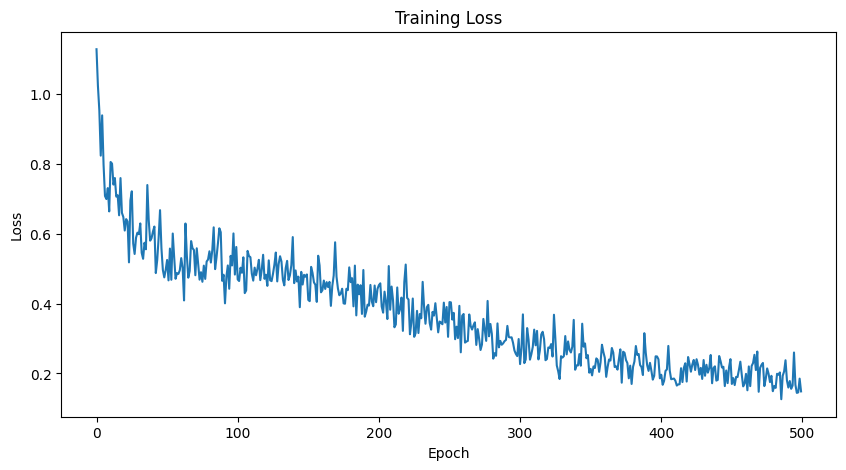

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


## Gaussin Process Regression

### Incorporating Gaussian Process Regression (GPR) as an Energy-Based Guidance

In the diffusion model, our reverse process aims to reconstruct a cleaner sample $ x_0 $ from a noisy $ x_t $. Without guidance, the model simply predicts the noise $\epsilon$ at each step and tries to invert the forward noising process. However, this alone does not guarantee that the recovered sample aligns with additional knowledge or predictive distributions we might have about the data.

**Key Idea of GPR Guidance**:  
Gaussian Process Regression (GPR) gives us a predictive distribution for the target data at the test points. Suppose we have GPR predictions $\mu_{\text{GPR}}$ and $\sigma_{\text{GPR}}$ for a given time step in the test set. The GPR model essentially provides:
$$
y_{\text{test}} \sim N(\mu_{\text{GPR}}, \sigma_{\text{GPR}}^2).
$$
We can interpret $\mu_{\text{GPR}}$ and $\sigma_{\text{GPR}}$ as describing a "most likely" range for the clean underlying value at the test location. If we treat the diffusion output $ x_t $ as a random variable we are refining, we can define an energy function:
$$
E(x) = \frac{(x - \mu_{\text{GPR}})^2}{2 \sigma_{\text{GPR}}^2}.
$$
Minimizing this energy encourages $ x $ to be close to $\mu_{\text{GPR}}$, leveraging the GPR prediction.

**From Energy to Guidance in the Diffusion Reverse Process**:  
During the reverse diffusion steps, we have:
$$
x_t \leftarrow x_{t-1} \quad \text{with some predicted noise correction}.
$$
By adding a gradient-based correction term derived from the GPR energy, we incorporate a "pull" towards the GPR mean:
$$
\nabla_x E(x) = \frac{x - \mu_{\text{GPR}}}{\sigma_{\text{GPR}}^2}.
$$
We adjust $x_t$ by moving it opposite to the gradient of $E(x)$:
$$
x_t \leftarrow x_t - \eta \cdot \alpha_{\text{guidance}} \nabla_x E(x).
$$
Here, $\eta$ is a step size and $\alpha_{\text{guidance}}$ controls how strongly we rely on GPR guidance.

By introducing GPR as an energy-based guidance, we steer the diffusion model's reconstructed samples towards values that GPR deems more plausible or accurate. Essentially, GPR provides external knowledge (in the form of a predicted mean and variance) to refine the final output. This allows the final denoised signal to not only be clean but also better aligned with the predictive insights provided by GPR.


In [11]:
kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

X_train = time_train.reshape(-1, 1)
y_train_gpr = y_train

gpr.fit(X_train, y_train_gpr)


GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=10)

In [12]:
alpha = 1.0
eta = 0.05

X_test = time_test.reshape(-1, 1)
y_pred_gpr, y_std_gpr = gpr.predict(X_test, return_std=True)

y_mean_gpr = torch.tensor(y_pred_gpr, dtype=torch.float32).to(device)
y_std_gpr_tensor = torch.tensor(y_std_gpr, dtype=torch.float32).to(device)


In [13]:
def diffusion_reverse_process(model, time_test_tensor, num_steps, alphas, alpha_bars, betas,
                              y_mean_gpr, y_std_gpr, alpha_guidance=0.0, eta=0.05):
    x_t = torch.randn(len(time_test_tensor), dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        for t_inv in range(num_steps - 1, -1, -1):
            timestep = torch.full((len(time_test_tensor),), t_inv, dtype=torch.long).to(device)

            alpha_t = torch.tensor(alphas[t_inv], dtype=torch.float32, device=device)
            alpha_bar_t = torch.tensor(alpha_bars[t_inv], dtype=torch.float32, device=device)
            beta_t = torch.tensor(betas[t_inv], dtype=torch.float32, device=device)

            epsilon_pred = model(x_t, time_test_tensor, timestep)

            one_minus_alpha_bar = torch.sqrt(1 - alpha_bar_t)
            sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)

            x0_pred = (x_t - one_minus_alpha_bar * epsilon_pred) / sqrt_alpha_bar_t

            if t_inv > 0:
                noise = torch.randn(len(time_test_tensor), dtype=torch.float32).to(device)
                x_t = torch.sqrt(alpha_t)*x0_pred + torch.sqrt(beta_t)*noise
            else:
                x_t = x0_pred

            if alpha_guidance > 0:
                grad_E_gpr = (x_t - y_mean_gpr) / (y_std_gpr**2)
                x_t = x_t - eta * alpha_guidance * grad_E_gpr
    return x_t

time_test_tensor = torch.tensor(time_test, dtype=torch.float32).to(device)

# Without Guidance
y_pred_dnn_no_guid = diffusion_reverse_process(model, time_test_tensor, num_diffusion_steps, alphas, alpha_bars, betas,
                                               y_mean_gpr, y_std_gpr_tensor, alpha_guidance=0.0, eta=0.05).cpu().numpy()

# With Guidance
y_pred_dnn_guid = diffusion_reverse_process(model, time_test_tensor, num_diffusion_steps, alphas, alpha_bars, betas,
                                            y_mean_gpr, y_std_gpr_tensor, alpha_guidance=1.0, eta=0.05).cpu().numpy()


After integrating GPR as an energy-based guidance into the diffusion reverse process, the cell below retrieves predictions under two conditions: without guidance and with guidance. Without guidance, the diffusion model simply attempts to revert the noisy data to a cleaner state based on its learned noise-reversal capabilities. With GPR guidance, however, we introduce an external pull towards values favored by the GPR prediction.


In [14]:
no_guid_results = np.column_stack((time_test, y_true_test, y_test, y_pred_dnn_no_guid))
guid_results = np.column_stack((time_test, y_true_test, y_test, y_pred_dnn_guid))
gpr_results = np.column_stack((time_test, y_true_test, y_test, y_pred_gpr, y_std_gpr))

no_guid_sorted = no_guid_results[np.argsort(no_guid_results[:, 0])]
guid_sorted = guid_results[np.argsort(guid_results[:, 0])]
gpr_sorted = gpr_results[np.argsort(gpr_results[:, 0])]

time_test_sorted = no_guid_sorted[:, 0]
y_true_test_sorted = no_guid_sorted[:, 1]
y_test_sorted = no_guid_sorted[:, 2]
y_pred_dnn_no_guid_sorted = no_guid_sorted[:, 3]
y_pred_dnn_guid_sorted = guid_sorted[:, 3]

y_pred_gpr_sorted = gpr_sorted[:, 3]
y_std_gpr_sorted = gpr_sorted[:, 4]


### Comparison with and without GPR Guidance
The plot compares the true underlying function, the noisy observations, the diffusion model’s predictions without guidance, and the predictions when GPR guidance is applied. By visually inspecting the results, it becomes clear that incorporating GPR guidance helps the diffusion model produce predictions more closely aligned with the true underlying signal. The guided predictions deviate less from the true curve than the unguided ones, illustrating that the energy-based guidance effectively refines the final outcome of the diffusion-based reconstruction process.

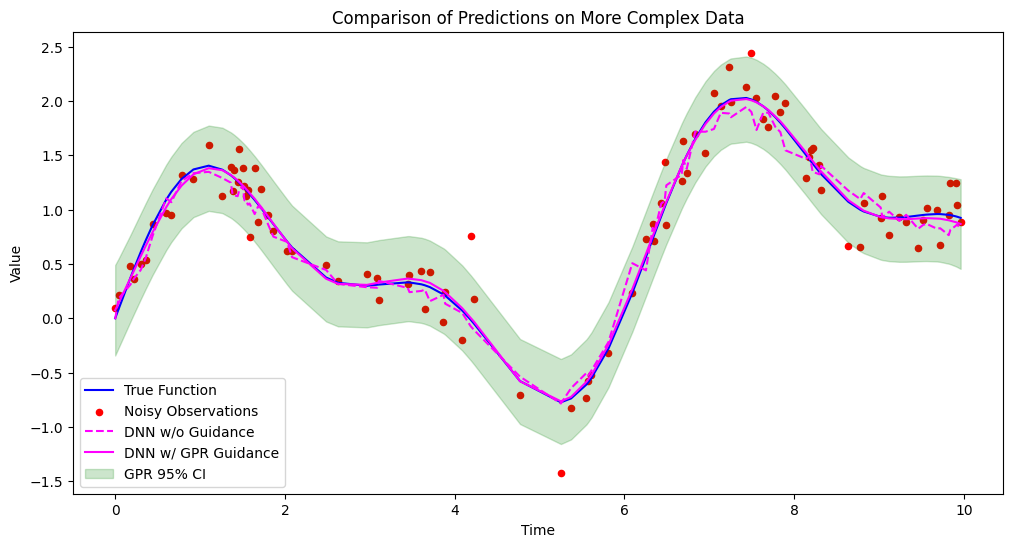

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(time_test_sorted, y_true_test_sorted, label='True Function', color='blue')
plt.scatter(time_test_sorted, y_test_sorted, color='red', s=20, label='Noisy Observations')
plt.plot(time_test_sorted, y_pred_dnn_no_guid_sorted, label='DNN w/o Guidance', color='magenta', linestyle='--')
plt.plot(time_test_sorted, y_pred_dnn_guid_sorted, label='DNN w/ GPR Guidance', color='magenta')
plt.fill_between(time_test_sorted,
                 y_pred_gpr_sorted - 1.96 * y_std_gpr_sorted,
                 y_pred_gpr_sorted + 1.96 * y_std_gpr_sorted,
                 color='green', alpha=0.2, label='GPR 95% CI')
plt.title('Comparison of Predictions on More Complex Data')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()

In [16]:
mse_no_guid = mean_squared_error(y_true_test_sorted, y_pred_dnn_no_guid_sorted)
mse_guid = mean_squared_error(y_true_test_sorted, y_pred_dnn_guid_sorted)
mse_gpr = mean_squared_error(y_true_test_sorted, y_pred_gpr_sorted)

print(f'DNN MSE (no guidance): {mse_no_guid:.6f}')
print(f'DNN MSE (with guidance): {mse_guid:.6f}')
print(f'GPR MSE: {mse_gpr:.6f}')

DNN MSE (no guidance): 0.009734
DNN MSE (with guidance): 0.000784
GPR MSE: 0.000793


### Summary


In summary, as we integrate GPR guidance, the diffusion model not only denoises but also leverages the statistical insights provided by GPR. This results in a more accurate estimation than the baseline diffusion model alone, showing the practical benefit of coupling these two approaches.

## Experiment with Stein Variational Gradient (SVG)

The following sections extend the previous ideas to a [real-world dataset (PM2.5)](https://archive.ics.uci.edu/dataset/381/beijing+pm2+5+data) and incorporate Stein Variational Gradient Descent (SVGD) steps. Unlike the synthetic sine wave data, we now deal with measurements that lack a known closed-form "true function." Instead, we assume the observed PM2.5 data as our baseline reality. By introducing noise, we create a scenario akin to the synthetic case, but more complex and realistic.

Our aim remains to use the diffusion model to denoise and reconstruct cleaner signals from noisy inputs. However, now we add two critical layers of complexity and refinement:

1. **Realistic Data (PM2.5)**: Instead of a simple sine-based function, the PM2.5 dataset reflects real environmental conditions and inherently contains noise and complexity not captured by simple functional forms.

2. **Stein Variational Gradient Descent (SVGD)**: After using GPR as an energy-based guidance to improve the diffusion reverse process, we now add SVGD steps. SVGD provides a kernel-based, non-parametric way to further refine the final samples. Essentially, after the reverse diffusion steps guided by GPR, we apply SVGD updates to push our samples to better align with the GPR-induced energy landscape. Conceptually, if we consider our final samples as particles, SVGD updates these particles to minimize a certain divergence measure (like KL divergence) to a target distribution defined by GPR guidance.

From a mathematical standpoint, if the diffusion model provides a baseline distribution and GPR sets an energy landscape through a mean and variance prediction, then SVGD acts as an iterative algorithm to move our set of particles (the final samples) closer to the GPR-favored distribution. The SVGD updates rely on kernel methods and gradients of the log probability (or here, the negative energy) to iteratively enhance the sample quality.

By observing the final plot and metrics, one should see that:
- The baseline diffusion model without guidance is able to denoise but may not produce values closely aligned with the reality captured by PM2.5 data.
- Adding GPR guidance nudges the diffusion output closer to more plausible predictions, as informed by the GPR mean and variance.
- Introducing SVGD after GPR guidance refines these samples even further, achieving a final prediction more faithful to the underlying PM2.5 patterns than all previous methods.

## Set Up
Before we go, please download the following dataset in `csv` format and rename it as `Beijing_PM25.csv`.

[Beijing PM 2.5 download link](https://archive.ics.uci.edu/dataset/381/beijing+pm2+5+data)


In [17]:
###########################################
# 1. Load Data
###########################################
df = pd.read_csv('Beijing_PM25.csv')

df['datetime'] = pd.to_datetime(df[['year','month','day','hour']])
df.set_index('datetime', inplace=True)
df = df.sort_index()
df = df[['pm2.5']].dropna()

df = df.iloc[:2000]

time = np.linspace(0, 10, len(df))

y_true = df['pm2.5'].values
noise_std = 0.2
y_observed = y_true + noise_std * np.random.randn(len(y_true))

y_scaler = StandardScaler()
y_observed_scaled = y_scaler.fit_transform(y_observed.reshape(-1,1)).flatten()
y_true_scaled = y_scaler.transform(y_true.reshape(-1,1)).flatten()


## Train/Test Split

We randomly split the dataset into training and test sets. Unlike the synthetic case where shuffling was optional, here we allow shuffling to ensure a more general test scenario. The model will learn from one subset and be evaluated on another, guaranteeing a fair assessment of its predictive capabilities.

In [18]:
###########################################
# 2. Train/Test Split
###########################################
train_indices, test_indices = train_test_split(np.arange(len(time)), test_size=0.2, random_state=SEED, shuffle=True)

time_train = time[train_indices]
y_train_scaled = y_observed_scaled[train_indices]
y_true_train_scaled = y_true_scaled[train_indices]

time_test = time[test_indices]
y_test_scaled = y_observed_scaled[test_indices]
y_true_test_scaled = y_true_scaled[test_indices]


## Dataset Construction for Diffusion

This replicates the diffusion forward process on real data. For each sample and a random timestep $t$, `q_sample` generates a noisy version $x_t$. The dataset yields tuples of $(x_t, t)$ and the original noise $\epsilon$, enabling the model to learn denoising in a manner consistent with the diffusion framework established earlier.

In [19]:
###########################################
# 3. Dataset
###########################################
num_diffusion_steps = 100
beta_start = 0.0001
beta_end = 0.02
betas = np.linspace(beta_start, beta_end, num_diffusion_steps)
alphas = 1.0 - betas
alpha_bars = np.cumprod(alphas)

def q_sample(x0, t):
    if np.isscalar(t):
        t = np.full(len(x0), t)
    else:
        t = np.array(t)
    sqrt_alpha_bar_t = np.sqrt(alpha_bars[t])
    sqrt_one_minus_alpha_bar_t = np.sqrt(1 - alpha_bars[t])
    epsilon = np.random.randn(len(x0))
    x_t = sqrt_alpha_bar_t * x0 + sqrt_one_minus_alpha_bar_t * epsilon
    return x_t, epsilon

class DiffusionDataset(Dataset):
    def __init__(self, x0, time, num_steps):
        self.x0 = x0  # scaled된 y_true 값
        self.time = time
        self.num_steps = num_steps

    def __len__(self):
        return len(self.x0)

    def __getitem__(self, idx):
        t = np.random.randint(0, self.num_steps)
        x_t, epsilon = q_sample(self.x0[idx:idx+1], t)
        return {
            'x_t': x_t[0],
            'time': self.time[idx],
            'timestep': t,
            'epsilon': epsilon[0]
        }

train_dataset = DiffusionDataset(y_true_train_scaled, time_train, num_diffusion_steps)
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)

## Denoising Network

The `DenoisingNetwork` remains structurally identical to the previous examples. It learns a mapping from $(x_t, \text{time}, t)$ to the predicted noise $\hat{\epsilon}$. Training this network on PM2.5 data sets the stage for improving results via GPR guidance and SVGD steps.


In [20]:
###########################################
# 4. Denoising Network
###########################################
class DenoisingNetwork(nn.Module):
    def __init__(self, num_steps):
        super(DenoisingNetwork, self).__init__()
        self.time_embed = nn.Linear(1, 16)
        self.timestep_embed = nn.Embedding(num_steps, 16)

        self.model = nn.Sequential(
            nn.Linear(1 + 16 + 16, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x_t, time, timestep):
        time = time.unsqueeze(1)
        time_emb = self.time_embed(time)
        timestep_emb = self.timestep_embed(timestep)

        x_t = x_t.unsqueeze(1)
        inputs = torch.cat([x_t, time_emb, timestep_emb], dim=1)
        output = self.model(inputs)
        return output.squeeze()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

model = DenoisingNetwork(num_steps=num_diffusion_steps).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Using device: cpu


## Model Training

We train the diffusion model to predict $\epsilon$. Longer training (1000 epochs) gives the network ample time to understand the noise structure and learn a stable reverse diffusion mapping. After this step, the model can denoise samples but does not inherently ensure alignment with any external predictive model (GPR) yet.

In [21]:
###########################################
# 5. Model Training
###########################################
num_epochs = 1000
loss_history = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for batch in train_dataloader:
        x_t = batch['x_t'].float().to(device)
        time_input = batch['time'].float().to(device)
        timestep = batch['timestep'].long().to(device)
        epsilon = batch['epsilon'].float().to(device)

        optimizer.zero_grad()

        epsilon_pred = model(x_t, time_input, timestep)

        loss = criterion(epsilon_pred, epsilon)

        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x_t.size(0)

    average_loss = total_loss / len(train_dataset)
    loss_history.append(average_loss)

    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.6f}')


Epoch [50/1000], Loss: 0.620093
Epoch [100/1000], Loss: 0.643435
Epoch [150/1000], Loss: 0.557024
Epoch [200/1000], Loss: 0.645489
Epoch [250/1000], Loss: 0.614143
Epoch [300/1000], Loss: 0.576404
Epoch [350/1000], Loss: 0.571581
Epoch [400/1000], Loss: 0.586407
Epoch [450/1000], Loss: 0.554740
Epoch [500/1000], Loss: 0.545401
Epoch [550/1000], Loss: 0.523996
Epoch [600/1000], Loss: 0.601944
Epoch [650/1000], Loss: 0.534674
Epoch [700/1000], Loss: 0.510245
Epoch [750/1000], Loss: 0.560864
Epoch [800/1000], Loss: 0.538995
Epoch [850/1000], Loss: 0.550728
Epoch [900/1000], Loss: 0.566818
Epoch [950/1000], Loss: 0.530035
Epoch [1000/1000], Loss: 0.551404


### GPR Fitting

When we incorporate Gaussian Process Regression (GPR) into the workflow, our goal is to use its predictive distribution to guide the diffusion model's reverse process. By modeling the relationship between time and the scaled PM2.5 values, GPR provides a predictive mean and variance for each test point. Formally, for a test time point, GPR yields a distribution:
$$ y_{\text{test}} \sim N(\mu_{\text{GPR}}, \sigma_{\text{GPR}}^2). $$

This predictive distribution sets the stage for energy-based guidance. We define an energy function based on the GPR predictions:
$$ E(x) = \frac{(x - \mu_{\text{GPR}})^2}{2 \sigma_{\text{GPR}}^2}, $$
which, when minimized, encourages our reconstructed samples to be closer to $\mu_{\text{GPR}}$. This gives the diffusion model external knowledge about plausible target values, improving its reconstruction quality beyond simple denoising.


In [22]:
###########################################
# 6. Gaussian Process Regression Fitting
###########################################
kernel = RBF(length_scale=1.0) + WhiteKernel(noise_level=1.0)
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)

X_train = time_train.reshape(-1, 1)
X_train_gpr =X_train
y_train_gpr = y_train_scaled

gpr.fit(X_train_gpr, y_train_gpr)

alpha = 1.0
eta = 0.05

X_test = time_test.reshape(-1, 1)
y_pred_gpr_scaled, y_std_gpr_scaled = gpr.predict(X_test, return_std=True)

y_mean_gpr_scaled = torch.tensor(y_pred_gpr_scaled, dtype=torch.float32).to(device)
y_std_gpr_tensor_scaled = torch.tensor(y_std_gpr_scaled, dtype=torch.float32).to(device)


## Diffusion Reverse Process

During the reverse diffusion process, if we consider the GPR predictive distribution and define an energy function based on the GPR mean and variance:
$$ E(x) = \frac{(x - \mu_{\text{GPR}})^2}{2 \sigma_{\text{GPR}}^2}, $$
the gradient of this energy with respect to $ x $ is:
$$ \nabla_x E(x) = \frac{x - \mu_{\text{GPR}}}{\sigma_{\text{GPR}}^2}. $$

By incorporating this gradient into the reverse steps, we update:
$$ x_t \leftarrow x_t - \eta \cdot \alpha_{\text{guidance}} \nabla_x E(x), $$
which guideds the reconstructed sample $ x_t $ closer to the GPR-predicted mean $ \mu_{\text{GPR}} $.

In [23]:
###########################################
# 7. Diffusion Reverse Process
###########################################
def diffusion_reverse_process(model, time_test_tensor, num_steps, alphas, alpha_bars, betas,
                              y_mean_gpr, y_std_gpr, alpha_guidance=0.0, eta=0.05):
    x_t = torch.randn(len(time_test_tensor), dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        for t_inv in range(num_steps - 1, -1, -1):
            timestep = torch.full((len(time_test_tensor),), t_inv, dtype=torch.long).to(device)

            alpha_t = torch.tensor(alphas[t_inv], dtype=torch.float32, device=device)
            alpha_bar_t = torch.tensor(alpha_bars[t_inv], dtype=torch.float32, device=device)
            beta_t = torch.tensor(betas[t_inv], dtype=torch.float32, device=device)

            epsilon_pred = model(x_t, time_test_tensor, timestep)

            one_minus_alpha_bar = torch.sqrt(1 - alpha_bar_t)
            sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)

            x0_pred = (x_t - one_minus_alpha_bar * epsilon_pred) / sqrt_alpha_bar_t

            if t_inv > 0:
                noise = torch.randn(len(time_test_tensor), dtype=torch.float32).to(device)
                x_t = torch.sqrt(alpha_t)*x0_pred + torch.sqrt(beta_t)*noise
            else:
                x_t = x0_pred

            if alpha_guidance > 0:
                grad_E_gpr = (x_t - y_mean_gpr) / (y_std_gpr**2)
                x_t = x_t - eta * alpha_guidance * grad_E_gpr
    return x_t

### Stein Variational Gradient Descent (SVGD)

After integrating GPR guidance, we still may want to refine our samples further to better approximate a desired target distribution. SVGD offers a particle-based inference approach that iteratively transforms a set of samples (particles) to match a target distribution defined through energy functions or log probability gradients.

**Key Concept**:  
We consider the final samples $x$ produced by the diffusion reverse process with GPR guidance as particles. Our goal is to move these particles closer to the GPR-induced target distribution. SVGD does this by updating $x$ through:
$$ x \leftarrow x + \eta \phi(x), $$
where $\phi(x)$ is derived from a combination of the gradient of the log probability (related to $E(x)$) and interactions between particles via a kernel function. This ensures particles spread out appropriately, reducing mode collapse and improving approximation quality.

**Mathematical Details**:
1. **Kernel Computation**:  
   We use an RBF kernel:
   $$ K(x_i, x_j) = \exp\left(-\frac{(x_i - x_j)^2}{h}\right), $$
   with $h$ chosen adaptively. This kernel encourages a balance between attracting particles towards regions of high probability and repelling them to maintain diversity.

2. **Gradient of Log Probability**:  
   Since we have $ E(x) = \frac{(x - \mu_{\text{GPR}})^2}{2 \sigma_{\text{GPR}}^2} $, its gradient is:
   $$ \nabla_x E(x) = \frac{x - \mu_{\text{GPR}}}{\sigma_{\text{GPR}}^2}. $$
   Negating this gives the gradient of the log probability:
   $$ \nabla_x \log p(x) \propto -(x - \mu_{\text{GPR}})/\sigma_{\text{GPR}}^2. $$

3. **SVGD Update**:  
   With $N$ particles and kernel $K$, the SVGD update rule:
   $$ \phi(x_i) = \frac{1}{N} \sum_{j=1}^N \biggl[ K(x_j, x_i) \nabla_{x_j}\log p(x_j) + \nabla_{x_j} K(x_j, x_i)\biggr]. $$
   In code, this is approximated by `grad_log_q_term` and `dK_term`. The combination of these terms moves each particle along a direction that increases their overall fit to the target distribution suggested by GPR.

**Intuition**:
- Diffusion + GPR guidance brings samples closer to a plausible mean value predicted by GPR.
- SVGD further refines these samples, ensuring that they are well-distributed and better approximate the underlying distribution. This can lead to improved predictive performance and more stable results.

The code below defines:
- `rbf_kernel`: computes the RBF kernel matrix $K$.
- `svgd_update`: applies one SVGD iteration to move particles closer to the GPR-defined target.
- `diffusion_reverse_process_with_svgd`: runs the diffusion reverse steps with GPR guidance and then applies multiple SVGD updates to refine the final samples.

When executed, this approach should yield even better performance than diffusion with GPR guidance alone, as the SVGD step helps the final samples form a more accurate approximation of the target distribution.


In [24]:
###########################################
# 8. Stein Variational Gradient Descent
###########################################

def rbf_kernel(x, h=None):
    x_row = x.unsqueeze(1)
    x_col = x.unsqueeze(0)
    dist = (x_row - x_col)**2
    if h is None:
        h = torch.median(dist)
        h = h if h > 0 else torch.tensor(1.0, device=x.device)
    k = torch.exp(-dist / h)
    return k

def svgd_update(x, y_mean, y_std, eta=0.01, alpha=1.0):
    grad_log_q = -(x - y_mean) / (y_std**2)
    K = rbf_kernel(x)
    dK = -2*(x.unsqueeze(1)-x.unsqueeze(0))*K
    N = x.shape[0]
    grad_log_q_term = (K @ grad_log_q) / N
    dK_term = torch.sum(dK, dim=0)/N
    phi = grad_log_q_term + 0.01 * dK_term
    x = x + eta * alpha * phi
    return x

def diffusion_reverse_process_with_svgd(model, time_test_tensor, num_steps, alphas, alpha_bars, betas,
                                        y_mean_gpr, y_std_gpr, alpha_guidance=1.0, eta=0.05, svgd_steps=5):
    x_t = torch.randn(len(time_test_tensor), dtype=torch.float32).to(device)
    model.eval()
    with torch.no_grad():
        for t_inv in range(num_steps - 1, -1, -1):
            timestep = torch.full((len(time_test_tensor),), t_inv, dtype=torch.long).to(device)
            alpha_t = torch.tensor(alphas[t_inv], dtype=torch.float32, device=device)
            alpha_bar_t = torch.tensor(alpha_bars[t_inv], dtype=torch.float32, device=device)
            beta_t = torch.tensor(betas[t_inv], dtype=torch.float32, device=device)

            epsilon_pred = model(x_t, time_test_tensor, timestep)

            one_minus_alpha_bar = torch.sqrt(1 - alpha_bar_t)
            sqrt_alpha_bar_t = torch.sqrt(alpha_bar_t)
            x0_pred = (x_t - one_minus_alpha_bar * epsilon_pred) / sqrt_alpha_bar_t

            if t_inv > 0:
                noise = torch.randn(len(time_test_tensor), dtype=torch.float32).to(device)
                x_t = torch.sqrt(alpha_t)*x0_pred + torch.sqrt(beta_t)*noise
            else:
                x_t = x0_pred

            if alpha_guidance > 0:
                grad_E_gpr = (x_t - y_mean_gpr)/(y_std_gpr**2)
                x_t = x_t - eta * alpha_guidance * grad_E_gpr

        for _ in range(svgd_steps):
            x_t = svgd_update(x_t, y_mean_gpr, y_std_gpr, eta=0.01, alpha=1.0)

    return x_t

We execute the diffusion reverse process under three conditions to illustrate the effect of guidance and SVGD refinement:

1. **Without Guidance**:  
   We run the reverse diffusion steps purely based on the learned noise removal, producing a baseline reconstruction that may not align well with the underlying PM2.5 trends once restored to the original scale.

2. **With Guidance** ($\alpha_{\text{guidance}} > 0$):  
   By using the GPR predictions as an energy-based prior, each reverse step includes a small correction:
   $$
   x_t \leftarrow x_t - \eta \cdot \alpha_{\text{guidance}} \frac{x_t - \mu_{\text{GPR}}}{\sigma_{\text{GPR}}^2}.
   $$
   This nudges $x_t$ towards the GPR mean, resulting in predictions that should more closely follow the actual data patterns compared to the unguided approach.

3. **With Guidance + SVGD**:  
   After applying GPR guidance, we further refine the samples using SVGD updates. This step:
   - Encourages the final samples to better approximate the target distribution defined by GPR.
   - Mitigates issues like mode collapse or insufficient spread of the samples.
   
By comparing the predictions from all three scenarios, we can quantitatively and visually confirm that adding GPR guidance improves performance over baseline diffusion, and including SVGD steps yields an even tighter fit to the true underlying PM2.5 data.

In [25]:
###########################################
# 9. Diffusion Reverse Process
###########################################

time_test_tensor = torch.tensor(time_test, dtype=torch.float32).to(device)

# Without Guidance
y_pred_dnn_no_guid_scaled = diffusion_reverse_process(model, time_test_tensor, num_diffusion_steps, alphas, alpha_bars, betas,
                                                      y_mean_gpr_scaled, y_std_gpr_tensor_scaled, alpha_guidance=0.0, eta=0.05).cpu().numpy()

# With Guidance
y_pred_dnn_guid_scaled = diffusion_reverse_process(model, time_test_tensor, num_diffusion_steps, alphas, alpha_bars, betas,
                                                   y_mean_gpr_scaled, y_std_gpr_tensor_scaled, alpha_guidance=1.0, eta=0.05).cpu().numpy()

y_pred_dnn_svgd_scaled = diffusion_reverse_process_with_svgd(model, time_test_tensor, num_diffusion_steps, alphas, alpha_bars, betas,
                                                             y_mean_gpr_scaled, y_std_gpr_tensor_scaled, alpha_guidance=1.0, eta=0.05, svgd_steps=5).cpu().numpy()


In [26]:
###########################################
# 10. Result
###########################################
y_pred_dnn_no_guid = y_scaler.inverse_transform(y_pred_dnn_no_guid_scaled.reshape(-1,1)).flatten()
y_pred_dnn_guid = y_scaler.inverse_transform(y_pred_dnn_guid_scaled.reshape(-1,1)).flatten()
y_pred_dnn_svgd = y_scaler.inverse_transform(y_pred_dnn_svgd_scaled.reshape(-1,1)).flatten()
y_pred_gpr = y_scaler.inverse_transform(y_pred_gpr_scaled.reshape(-1,1)).flatten()

y_true_test_rescaled = y_scaler.inverse_transform(y_true_test_scaled.reshape(-1,1)).flatten()
y_test_rescaled = y_scaler.inverse_transform(y_test_scaled.reshape(-1,1)).flatten()

no_guid_results = np.column_stack((time_test, y_true_test_rescaled, y_test_rescaled, y_pred_dnn_no_guid))
guid_results = np.column_stack((time_test, y_true_test_rescaled, y_test_rescaled, y_pred_dnn_guid))
svgd_results = np.column_stack((time_test, y_true_test_rescaled, y_test_rescaled, y_pred_dnn_svgd))
gpr_results = np.column_stack((time_test, y_true_test_rescaled, y_test_rescaled, y_pred_gpr, y_std_gpr_scaled))

no_guid_sorted = no_guid_results[np.argsort(no_guid_results[:, 0])]
guid_sorted = guid_results[np.argsort(guid_results[:, 0])]
svgd_sorted = svgd_results[np.argsort(svgd_results[:, 0])]
gpr_sorted = gpr_results[np.argsort(gpr_results[:, 0])]

time_test_sorted = no_guid_sorted[:, 0]
y_true_test_sorted = no_guid_sorted[:, 1]
y_test_sorted = no_guid_sorted[:, 2]
y_pred_dnn_no_guid_sorted = no_guid_sorted[:, 3]
y_pred_dnn_guid_sorted = guid_sorted[:, 3]
y_pred_dnn_svgd_sorted = svgd_sorted[:, 3]

y_pred_gpr_sorted = gpr_sorted[:, 3]
y_std_gpr_sorted = gpr_sorted[:, 4]

mse_no_guid = mean_squared_error(y_true_test_sorted, y_pred_dnn_no_guid_sorted)
mse_guid = mean_squared_error(y_true_test_sorted, y_pred_dnn_guid_sorted)
mse_svgd = mean_squared_error(y_true_test_sorted, y_pred_dnn_svgd_sorted)
mse_gpr = mean_squared_error(y_true_test_sorted, y_pred_gpr_sorted)

print(f'DNN MSE (no guidance): {mse_no_guid:.6f}')
print(f'DNN MSE (GPR guidance): {mse_guid:.6f}')
print(f'DNN MSE (GPR guidance + SVGD): {mse_svgd:.6f}')
print(f'GPR MSE: {mse_gpr:.6f}')


DNN MSE (no guidance): 8081.047724
DNN MSE (GPR guidance): 1791.337516
DNN MSE (GPR guidance + SVGD): 1794.891727
GPR MSE: 1811.163165


After all the steps—baseline diffusion denoising, adding GPR guidance, and finally applying SVGD updates—this cell visualizes the ultimate results on the PM2.5 dataset. Each curve on the plot corresponds to a different configuration:

- **DNN w/o Guidance**: Shows what happens when the diffusion model reconstructs data without any external cues. Although some noise is removed, the predictions may still deviate significantly from the true PM2.5 values.
- **DNN w/ GPR Guidance**: Incorporating the GPR-based energy function aligns the reconstructed samples more closely with the underlying trends. The predictions hug the true function more tightly, indicating the GPR guidance is effective.
- **DNN w/ GPR Guidance + SVGD**: By adding SVGD refinement after GPR guidance, we push the samples into an even more accurate configuration. SVGD helps the final predictions better approximate the target distribution suggested by GPR, leading to a noticeable improvement in predictive fidelity.


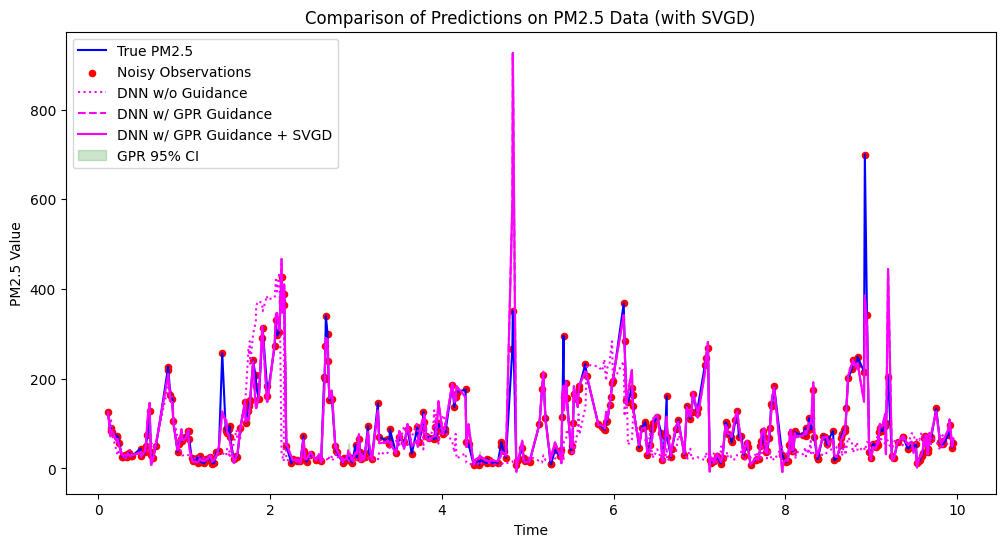

In [27]:
###########################################
# 11. Visualization
###########################################

plt.figure(figsize=(12, 6))
plt.plot(time_test_sorted, y_true_test_sorted, label='True PM2.5', color='blue')
plt.scatter(time_test_sorted, y_test_sorted, color='red', s=20, label='Noisy Observations')
plt.plot(time_test_sorted, y_pred_dnn_no_guid_sorted, label='DNN w/o Guidance', color='magenta', linestyle=':')
plt.plot(time_test_sorted, y_pred_dnn_guid_sorted, label='DNN w/ GPR Guidance', color='magenta', linestyle='--')
plt.plot(time_test_sorted, y_pred_dnn_svgd_sorted, label='DNN w/ GPR Guidance + SVGD', color='magenta')
plt.fill_between(time_test_sorted,
                 y_pred_gpr_sorted - 1.96 * y_std_gpr_sorted,
                 y_pred_gpr_sorted + 1.96 * y_std_gpr_sorted,
                 color='green', alpha=0.2, label='GPR 95% CI')
plt.title('Comparison of Predictions on PM2.5 Data (with SVGD)')
plt.xlabel('Time')
plt.ylabel('PM2.5 Value')
plt.legend()
plt.show()

## Conclusion and Limitations

We explored how a diffusion model, when combined with Gaussian Process Regression (GPR) and further refined via Stein Variational Gradient Descent (SVGD), can produce more accurate predictions for a real-world time series dataset (PM2.5 measurements).

**However, several limitations remain**:

- **Conceptual Mismatch for Future Prediction**:  
  While diffusion models excel at noise removal and generative tasks, using them in a straightforward manner for future prediction of a time series may not be optimal. The setup here treats the problem as if it were a denoising task, not a direct forecasting problem. A more direct forecasting model or a modified diffusion framework that explicitly models temporal dependencies might perform better.

- **Computational Complexity**:  
  Diffusion models, GPR, and SVGD each introduce their own computational overhead. For large datasets, training and inference can become slow, especially if high-dimensional data or more complex kernels are involved.

- **Lack of External Features**:  
  Here, we only used time and the target series values. Real PM2.5 levels depend on weather, geography, and other external factors. Incorporating additional features might improve model performance and reduce reliance on these more complex inference techniques.

Overall, while this approach demonstrates a creative integration of diffusion models, GPR, and SVGD, it should be seen as an experimental framework rather than a definitive solution to time series forecasting. Future work could explore more direct forecasting methods, advanced architectures tailored to time series dynamics, or additional contextual features to address these limitations.
